---
<div class="alert alert-block alert-success">

## Комментарий от наставника

Привет! Спасибо за исследование!
    
Из плюсов отметил:
- Хорошая предобработка данных и исследовательский анализ
- Понравился корреляционный анализ
- Корректно выполнена кластеризация пользователей
- Мне очень сильно понравилось как реализован анализ: реализованы функции для подсчета всех метрик и объединяющая функция: в итоге на каждый кластер мы имеем кучу метрик и прочей информации и делаем дальше продуктовое описание этих групп - очень круто!
- Очень понравились финальные выводы и рекоммендации: они тесто связаны с увиденными в данных паттернами и действительно ценны для бизнеса
- Хорошая презентация, богатая выводами и визуализацией!
    
Точки роста и несовсем верные решения:
- Я бы начинал анализ с построения гистограммы частоты действий пользователей - сразу дает представление о популярности и месте целевого действия в пути пользователей
- Для гипотезы про конверсию из разных источников надо было применять поправку на множественное тестирование
</div>

---

# Анализ поведения пользователей в мобильном приложении "Ненужные вещи"

Датасет содержит данные о событиях (mobile_dataset), совершенных в мобильном приложении "Ненужные вещи". В нем пользователи продают свои ненужные вещи, размещая их на доске объявлений. При этом мобильное приложение можно установить с разных источников (mobile_sources).

В датасете содержатся данные пользователей, впервые совершивших действия в приложении после 7 октября 2019 года.

### Цели:
- Проанализировать связь целевого события — просмотра контактов — и других действий пользователей.
- Заказчик данного исследования хочет посмотреть, каков портрет клиентов, входящих в "горячий" отток (активно пользовались приложением и ушли из приложения недавно);
- На основании нашего анализа к тем клиентам приложения, которые не просматриваю контакты и уходят в отток (или близки к этому), будут применяться точечные программы по удержанию клиентов и увеличению их вовлеченности.

### Задачи:
1. Провести исследовательский анализ данных (этап EDA).
2. На основании поведения клиентов определить, какие действия приводят к просмотру контактов продавца.
3. Проверить статистические гипотезы.
    
### Этапы проекта:
1. [Предобработка данных](#Предобработка_данных):
    - исследовать пропущенные значения;
    - посмотреть типы данных;
    - посмотреть дубликаты в данных (и обработать их при необходимости);
    - скорретировать наименование колонок (для увеличения читаемости);
    - посмотреть пропуски в данных.
2. [Исследовательский анализ данных EDA](#EDA):
    - посмотреть, какие действия совершают пользователи в приложении, с какой частотой, их [корреляция](#corr) на уровне пользователей;
    - посмотреть на клиентов, которые представлены в датасетах: на какие группы можно разделить пользователей в зависимости от свершения целевого события (просмотр контакта);
    - разбить пользователей на группы можно, посмотрев общие признаки клиентов и их корреляцию, а можно инструментами [кластеризации](#ML) ML;
    - строим воронку по клиентам, смотрим взаимосвязь действий между собой;

3. [Работа с метриками и бизнес-показателями](#metrics): для каждой группы посмотреть метрики вовлеченности и активности и валидацию групп (если различия между группами будут небольшие - возможно стоит подумать над альтернативной разбивкой):
    - показатель возврата клиентов retention rate;
    - длительность сессии пользователя в приложении - посмотреть на промежуток времени между стартом сессий и посмотреть распределение по кластерам (если промежуток больше N часов (минут) - то считаем, что клиент закрыл приложение);
    - частота действий, 
    - конверсия.
4. [Проверка гипотез](#hyp): с тем пользователям, что ушли в отток (или близки к этому), начинаем проверять гипотезы по действиям пользователей.
    - [гипотеза 1](#hyp1): конверсия в просмотры контактов различается у этих двух групп (Одни пользователи совершают действия tips_show и tips_click, другие — только tips_show);
    - [гипотеза 2](#hyp2): по источникам привлечения пользователей - проблема self-selection - у пользователей разных источников может быть разная последовательность событий.    
5. Получение ["портрета" клиента](#summary), который уходит в отток и сформулировать действия для его удержания.

## Предобработка данных <a name="Предобработка_данных"></a>

Для начала импортируем необходимые библиотеки и прочитаем данные из двух файлов: события пользователей и источники привлечения пользователей.

In [1]:
import pandas as pd
import pandas_profiling
import statistics
import numpy as np
from datetime import datetime, timedelta

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
import math as mth
from scipy import stats as st

import seaborn as sns
import pandas.util.testing as tm
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
from matplotlib.pyplot import figure
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (15,8)
pd.options.mode.chained_assignment = None

import warnings
warnings.filterwarnings("ignore")

C:\Users\valen\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
datasets = pd.read_csv('C:/Users/valen/Downloads/mobile_dataset.csv')
soures = pd.read_csv('C:/Users/valen/Downloads/mobile_soures.csv')

Приведем названия столбцов к нижнему регистру, а также вставим нижнее подчеркивание. Так увеличивается читаемость названий столбцов.

In [3]:
for df in [datasets, soures]:      
    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.replace('.','_')
    
soures.columns = ['user_id','source']    

Проведем анализ данных таблиц: 
    * выведем пример данных, 
    * размерность таблицы,
    * посмотрим на типы данных, 
    * проверим пропуски,
    * дубликаты в данных,
    * и сразу же посмотрим базовую статистику.

Эту информацию можно получить с помощью библиотеки pandas_profiling. Но чтобы получить точечные данные по таблицам, напишем функцию df().

In [4]:
# уберем перенос строки
pd.options.display.expand_frame_repr = False

# анализ данных на типы данных, пропуски и дубликаты:
def info(df):
    
    """ Функция по предобработке данных  """
    
    print('Пример данных таблицы:\n%s\n\n'
          'Размерность таблицы:\n%s\n\n'
          'Типы строк таблицы:\n%s\n\n' 
          'Кол-во пропусков в таблице:\n%s\n\n'
          'Кол-во дубликатов в таблице:\n%s\n\n' 
          'Базовая статистика таблицы:\n%s\n\n' % (df.sample(3), 
                                                   df.shape,
                                                   df.dtypes, 
                                                   df.isnull().sum(), 
                                                   df[df.duplicated(keep=False)].shape[0],
                                                   df.describe()))

Посмотрим на данные по действиям пользователей:

In [5]:
info(datasets)

Пример данных таблицы:
                       event_time event_name                               user_id
22747  2019-10-16 13:57:54.654351  tips_show  3bc5febf-f692-4e36-9cfa-6e06392e339f
63817  2019-10-30 21:55:23.315109  tips_show  a2ffbe34-53bb-4394-a8d7-61a0617ad4dd
70862  2019-11-02 20:08:24.631047   search_1  f6f94ebe-e69a-4ae3-9fb0-312d52d35826

Размерность таблицы:
(74197, 3)

Типы строк таблицы:
event_time    object
event_name    object
user_id       object
dtype: object

Кол-во пропусков в таблице:
event_time    0
event_name    0
user_id       0
dtype: int64

Кол-во дубликатов в таблице:
0

Базовая статистика таблицы:
                        event_time event_name                               user_id
count                        74197      74197                                 74197
unique                       74197         16                                  4293
top     2019-10-30 19:12:38.255366  tips_show  cb36854f-570a-41f4-baa8-36680b396370
freq                       

Дата и время события должны иметь другой тип данных - поменяем.

In [6]:
datasets['event_time'] = pd.to_datetime(datasets['event_time'], format='%Y-%m-%d %H:%M:%S')

Видно, что есть события *contacts_show* и *show_contacts*, которые являтся идентичными.

In [7]:
datasets['event_name'] = datasets['event_name'].mask(datasets['event_name'] == 'contacts_show', 'show_contacts')

Данные по источникам привлечения пользователей:

In [8]:
info(soures)

Пример данных таблицы:
                                   user_id  source
27    e570de4f-5cf9-463c-80f6-4d81be19bf47   other
2590  7ab08c08-1b28-4ef9-ae54-96054b95c69b  yandex
4175  bd74ba4a-2531-4b4c-950a-84ea2bd7e0ac  yandex

Размерность таблицы:
(4293, 2)

Типы строк таблицы:
user_id    object
source     object
dtype: object

Кол-во пропусков в таблице:
user_id    0
source     0
dtype: int64

Кол-во дубликатов в таблице:
0

Базовая статистика таблицы:
                                     user_id  source
count                                   4293    4293
unique                                  4293       3
top     315fc0df-f2f0-4958-bbdb-24c6df4d8f6d  yandex
freq                                       1    1934




В итоге, для анализа у нас есть два датасета со следующей информацией:
Колонки в *mobile_sources.csv*: 

- `userId` — идентификатор пользователя,
- `source` — источник, с которого пользователь установил приложение.

Колонки в mobile_dataset.csv: **

- `event.time` — время совершения,
- `user.id` — идентификатор пользователя,
- `event.name` — действие пользователя.

Виды действий:

- `advert_open` — открыл карточки объявления,
- `photos_show` — просмотрел фотографий в объявлении,
- `tips_show` — увидел рекомендованные объявления,
- `tips_click` — кликнул по рекомендованному объявлению,
- `contacts_show` — посмотрел номер телефона,
- `contacts_call` — позвонил по номеру из объявления,
- `map` — открыл карту объявлений,
- `search_1`—`search_7` — разные действия, связанные с поиском по сайту,
- `favorites_add` — добавил объявление в избранное.

Данные по действиям пользователей приложения и источникам их привлечения готовы к последующему анализу.

Далее проведем исследовательский анализ данных EDA.

## Исследовательский анализ данных EDA <a name="EDA"></a>

Интересно распределение пользователей по источникам, поэтому добавим столбец с источником привлечения.

In [9]:
df = datasets.merge(soures, left_on=['user_id'], right_on=['user_id'])

Посмотрим, корреляцию событий в приложении на уровне пользователя. Сгруппируем события по пользователям и нарисуем тепловую карту. <a name="corr"></a>

In [10]:
user_by_events = pd.get_dummies(df, columns=['event_name']).groupby('user_id').agg('sum')
# сразу уберем приписку "event_name"
user_by_events.columns = user_by_events.columns.str.replace('event_name_','')

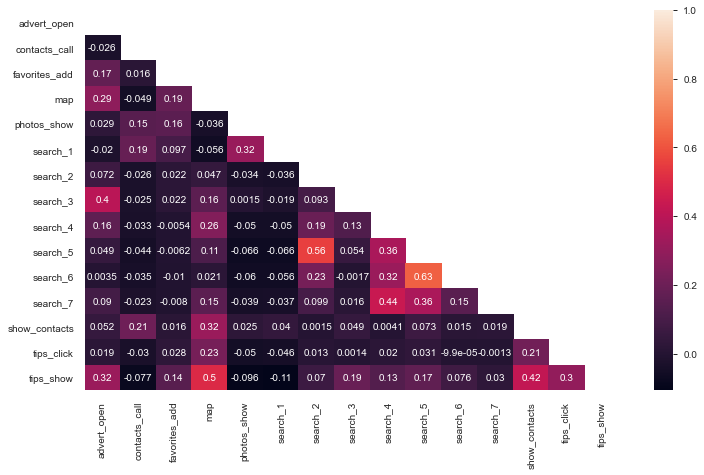

In [11]:
fig, ax = plt.subplots(figsize=(12,7))
matrix = np.triu(user_by_events.corr())
sns.heatmap(user_by_events.corr(), annot=True, mask=matrix)
plt.show()

Целевое событие (`просмотр контактов`) больше всего коррелирует с картой объявлений (клиент ориентируется на карте лучше относительно своего местоположения, и если объект продажи к нему ближе - смотрит контакт владельца).
Чтобы открыть карточку объявлений нужно сделать ряд действий по поиску 3 и (или) увидеть рекомендованные объявления.
Несколько действий поиска тоже имеют между собой связь - например, поиск 2, 5, 6, 7. А просматривают фотографии объектов больше те, что используют поиск 1.

Добавим столбец с днем, неделей, месяцем и посмотрим распеределение пользователей по времени.

In [12]:
df['day'] = df['event_time'].dt.day
df['week'] = df['event_time'].dt.week
df['month'] = df['event_time'].dt.month

Для того, чтобы понимать, какие клиенты и с какими признаками у нас есть, необходимо разделить их на группы и по ним провести исследовательский анализ.

Нужно разделить пользователей на группы, чтобы понимать, с какими клиентами имеем дело. Это позволит выстроить политику поведения с ними.
Используем `кластеризацию` пользователей. <a name="ML"></a> 
Для этого получим датасет пользователей с характерными признаками и целевой переменной (event_name_show_contacts).	

In [13]:
user_ml = pd.get_dummies(df[['user_id', 'event_name']], columns=['event_name']).groupby('user_id').agg('sum').reset_index()
# сразу уберем приписку "event_name"
user_ml.columns = user_ml.columns.str.replace('event_name_','')

Как мы видили ранее по матрице корреляции, есть несколько признаков, которые непосредственно влияют на то,чтобы клиент в конечном итоге позвонил продавцу:

* карта с объявлениями;
* просмотр фотографий;
* увидел рекомендации и зашел по рекомендации на страницу;
* действия поиска 5, 6

In [14]:
user_ml = user_ml[['user_id', 'map', 'photos_show', 'search_5', 'search_6', 
                  'tips_click', 'tips_show', 'show_contacts']]
user_ml.sample(3)

,user_id,map,photos_show,search_5,search_6,tips_click,tips_show,show_contacts
2640,9d6de32d-bef4-4703-a8ff-744e86a90a0b,4.0,0.0,0.0,0.0,0.0,1.0,0.0
1498,5a3f17df-9b8b-49b5-a132-cce4ba6601ae,4.0,0.0,0.0,0.0,0.0,11.0,1.0
3157,bddf472e-0fb2-42b2-9b42-d1a8765d82cf,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [15]:
# создаём объект класса scaler (нормализатор)
scaler = StandardScaler() 

# обучаем нормализатор и преобразуем набор данных
x_sc = scaler.fit_transform(user_ml.drop(columns = ['user_id','show_contacts'])) 

На выходе получим преобразованные таблицы объект-признак. Последовательно объединим близкие кластеры. Построим матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуем `дендрограмму`.

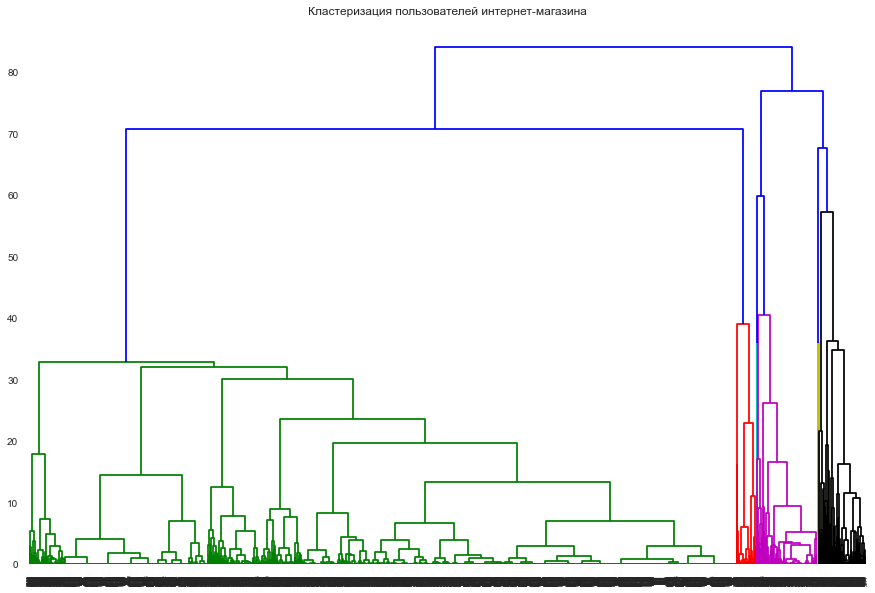

In [16]:
linked = linkage(x_sc, method = 'ward')

plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Кластеризация пользователей интернет-магазина')
plt.show()

По дендрограмме можно визуально оценить, сколько кластеров должно быть. А также прикинуть расстояние, после которого мы перестаём объединять объекты. Предложенное оптимальное число кластеров на основании графика выше `4` - четыре разных цветов на графике.

Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов. Алгоритм основан на предположении, что число кластеров (групп) заранее известно, поэтому зададим число кластеров - 4.

In [17]:
# задаём число кластеров, равное 4
km = KMeans(n_clusters = 4, random_state = 1) 

# применяем алгоритм к данным и формируем вектор кластеров
labels = km.fit_predict(x_sc) 

# сохраняем метки кластера в поле нашего датасета
user_ml['cluster_km'] = labels

# выводим статистику по средним значениям наших признаков по кластеру
user_ml.groupby('cluster_km').mean().round(3).reset_index().T

,0,1,2,3
cluster_km,0.000,1.000,2.000,3.00
map,0.847,0.706,10.642,0.68
photos_show,0.000,1.800,0.000,62.58
search_5,1.885,0.093,0.654,0.04
search_6,1.313,0.002,0.099,0.00
tips_click,0.133,0.109,4.346,0.00
tips_show,11.661,7.378,95.667,2.94
show_contacts,0.737,0.854,11.173,2.20


Если смотреть на средние значения признаков для кластеров можно заметить, что для всех признаков среднее значение по кластерам отличается. Посмотрим `метрику силуэта` для нашей кластеризации:

In [18]:
print('Silhouette_score: {:.2f}'.format(silhouette_score(x_sc, labels)))

Silhouette_score: 0.63


Значение метрики стремится к 1, значит кластеризация качественная.

Построим распределения признаков для кластеров.

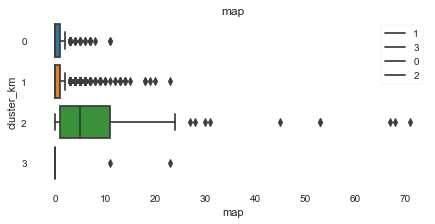

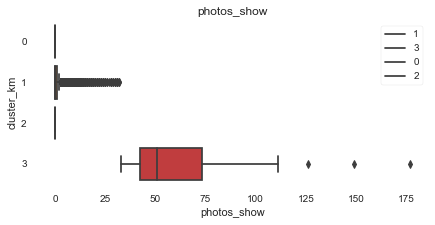

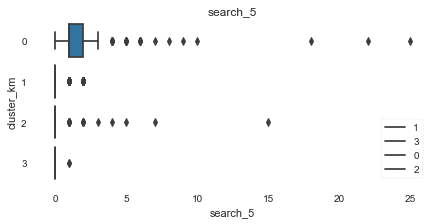

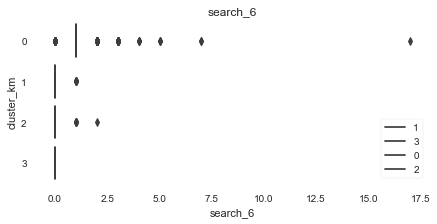

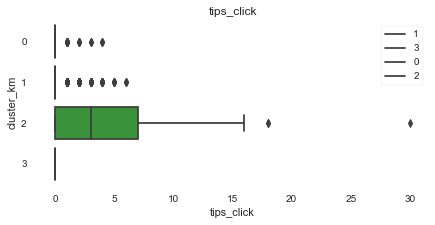

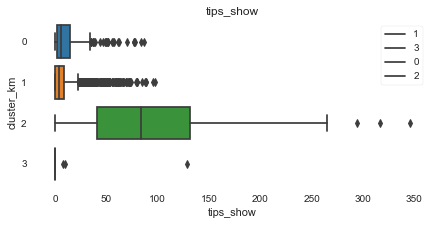

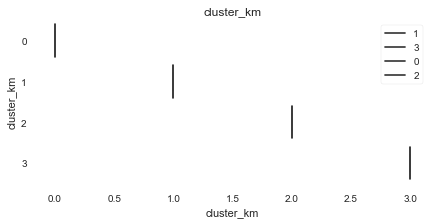

In [19]:
df_1 = user_ml.drop(columns = ['user_id','show_contacts'], axis=1)
for i, col in enumerate(df_1):
    fig, ax = plt.subplots(figsize=(7,3))
    sns.boxplot(data = df_1, x = col, y = 'cluster_km', orient = 'h')
    plt.title(str(col))
    plt.legend(labels=user_ml['cluster_km'].unique())
    plt.show()

Разделим общие данные по группам пользователей и начнем исследовать их.

In [20]:
def group(km):
    
    """ Функция выделения пользователей по 
        группам в отдельные датасеты       """  
    
    km = user_ml[user_ml['cluster_km'] == km]['user_id'].unique().tolist()
    return df[df['user_id'].isin(km)]

gr_0 = group(0)
gr_1 = group(1)
gr_2 = group(2)
gr_3 = group(3)

## Бизнес-метрики <a name="metrics"></a>

Ранее мы добавляли столбцы с днем, неделей и месяцем, теперь легко посмотреть действия пользователей по группам в разбивке по периодичности. Для автоматизации отрисовки графиков напишем функцию `bars()`.

In [21]:
def bars(data, column1, column2, func, title):
   
    """ Функция для отрисовки гистограмм  """
    
    visit_count = data.groupby([column1, 'source']).agg({column2:func}).reset_index()
    visit_count.columns = [column1, 'source', 'count']
    fig, ax = plt.subplots(figsize=(15,4))
    g = sns.barplot(x=column1, 
                    y = 'count', 
                    hue='source',
                    data = visit_count)
    ax.set_title(title, loc='left', pad=12, fontweight="bold") 
    sns.despine()
    plt.show()

Напишем исследовательскую функцию `EDA()`, которая будет выводить "портрет" каждой группы:
- Сколько людей пользуется приложением в день?
- Сколько людей пользуется приложением в неделю?
- Сколько людей пользуется приложением в месяц?
- Средняя длительность сессии по действиям
- Какие есть события в логах и с какой частотой встречаются
- Сколько пользователей совершило событие (потенциальные шаги воронки)
- Конверсия в воронке
- Показатель удержания клиентов.

Для отрисовки воронки напишем функцию `hist()`.

In [22]:
def hist(data, title, xlabel, ylabel):
    
    """ Функция для отрисовки горизонтальной гистограммы (воронки событий)  """
    
    fig, ax = plt.subplots(figsize=(15, 5))        # размер графика
    ax.barh(data.iloc[:,0], data.iloc[:,1]) # горизонтальный bar по данным 
    ax.set_title(title, loc='left', pad=12, fontweight="bold")   # заголовок графика + задаем шрифт
    for s in ['top','bottom','left','right']:                    # убираю все границы графика
        ax.spines[s].set_visible(False)                          
    ax.grid(b=True, color='grey', linestyle='-.', linewidth=0.5, alpha=0.2)  # задаю только промежуточные границы по значениям
    for i in ax.patches:                                                     # цикл по значениям
        ax.text(i.get_width()+2, i.get_y()+0.5, str(round((i.get_width()), 2)),   # задаю отступ (+) для подписи
                fontsize=10, fontweight='bold', color='black')                     # задаю шрифт и цвет подписи значения
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show() 

Чтобы выделить `сессии` из лога событий и посчитать ее длительность необходимо.
    
1) Для этого отсортируем их по user_id, тогда события каждого пользователя будут идти последовательно.

2) В колонке ’session_duration’ для каждого события отдельного пользователя посчитаем разницу между временем посещения страницы и временем посещения предыдущей страницы. Если страница была первой для пользователя, то значение в колонке ’session_duration’ будет NaT, т. к. нет предыдущего значения.

3) Находим такие события, которые будут начальными точками для сессий (NaT).

4) Из основного датафрейма ’df’ создадим вспомогательный датафрейм ’session_start_df’. Этот датафрейм будет содержать события, которые будут считаться первыми событиями сессий. К таким событиям относятся все события, которые произошли спустя более чем `30` минут после предыдущего, либо события, которые были первыми для пользователя (NaT в колонке ’session_duration’). Также создадим во вспомогательном датафрейме колонку ’session_id’, которая будет содержать в себе id первого события сессии. Она пригодится, чтобы корректно отобразить идентификатор сессии, когда будем объединять данные из основного и вспомогательного датафреймов.

5) С помощью функции merge_asof объединим между собой данные основного и вспомогательного датафреймов. Эта функция позволяет объединить данные двух датафреймов схожим образом с левым join’ом, но не по точному соответствию ключей, а по ближайшему.

Вынесем все действия в функцию `session_duration()`.

In [23]:
def session_duration(df):
    
    """ Функция расчета длительности сессии  """
    
    # 1
    df = df.sort_values(['user_id', 'event_time'])
    df['id'] = df.index

    # 2
    df['session_duration'] = df.groupby('user_id')['event_time'].diff(1)

    # 3-4
    sessions_start_df = df[(df['session_duration'].isnull()) | (df['session_duration'] > '1800 seconds')]
    sessions_start_df['session_id'] = sessions_start_df.index
    sessions_start_df['id'] = sessions_start_df.index

    # 5
    df = df.sort_values('id')
    sessions_start_df = sessions_start_df.sort_values('id')
    df = pd.merge_asof(df, sessions_start_df[['id','user_id','session_id']], on='id', by='user_id')

    df['session_duration_min'] = df['session_duration'].astype('timedelta64[m]') # переводим время в минуты
    
    plt.figure(figsize=(16,5));
    sns.boxplot(df.groupby('session_id')['session_duration_min'].sum());
    plt.title('Средняя длительность сессии, минуты', loc='left', pad=12, fontweight="bold");
    sns.set()
    return plt.show()

Напишем функцию, которая будет считать показать удержания клиентов по дням `RetentionaRate()`.

In [24]:
def RetentionaRate(df):
    
    """ Функция расчета показателя удержания клиента:
        пользователей выделяют в когорты по дате первого
        его действия, определяют кол-во новых 
        пользователей по дням                             
    """   
    
    df['event_time'] = pd.to_datetime(df['event_time'])
    first_date = df.groupby(['user_id'])['event_time'].min()
    first_date.name = 'first_visit_date'
    df = df.join(first_date, on='user_id')

    df['visit_day'] = df['event_time'].astype('datetime64[D]')
    df['first_visit_day'] = df['first_visit_date'].astype('datetime64[D]')

#      lifetime пользователя в рамках когорты
    df['cohort_lifetime'] = df['visit_day'] - df['first_visit_day']
    df['cohort_lifetime'] = df['cohort_lifetime'] / np.timedelta64(1,'D')
    df['cohort_lifetime'] = df['cohort_lifetime'].round().astype('int')
    
#     для каждой когорты количество активных пользователей
    cohorts = df.groupby(['first_visit_day','cohort_lifetime']).agg({'user_id':'nunique'}).reset_index()

#     исходное количество пользователей в когорте
    initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_visit_day','user_id']]
    initial_users_count = initial_users_count.rename(columns={'user_id':'cohort_users'})
    
#     Объединим данные по когортам с исходным количеством пользователей в когорте:
    cohorts = cohorts.merge(initial_users_count,on='first_visit_day')
    
#     рассчитаем Retention Rate
    cohorts['retention'] = cohorts['user_id']/cohorts['cohort_users']
    cohorts['first_visit_day'] = cohorts['first_visit_day'].dt.strftime('%Y-%m-%d')
    
    retention_pivot = cohorts.pivot_table(index='first_visit_day',
                                      columns='cohort_lifetime',
                                      values='retention',
                                      aggfunc='sum')
#     рисуем тепловую карту
    plt.figure(figsize=(7,5))
    plt.title('Как часто люди возвращаются?', loc='left', pad=12, fontweight="bold")
    sns.heatmap(retention_pivot,
                    annot=False, 
                    fmt='.1%', 
                    linewidths=1, 
                    linecolor='gray');

Соединим все функции в одну.

In [25]:
def EDA(df):
   
    """ Функция по анализу групп пользователей:
         - Сколько людей пользуется приложением в день?
         - Сколько людей пользуется приложением в неделю?
         - Сколько людей пользуется приложением в месяц?
         - Средняя длительность сессии
         - Какие есть события в логах и с какой частотой встречаются
         - Сколько пользователей совершило событие
         - Смотрим конверсию в воронке
         - Смотрим показатель удержания клиентов
    """
    
#     Сколько людей пользуется приложением в день?
    bars(df, 'day', 'user_id', 'nunique', 'Сколько людей пользуется приложением в день?')
    
#     Сколько людей пользуется приложением в неделю?
    bars(df, 'week', 'user_id', 'nunique', 'Сколько людей пользуется приложением в неделю?')

#     Сколько людей пользуется приложением в месяц?
    bars(df, 'month', 'user_id', 'nunique', 'Сколько людей пользуется приложением в месяц?')
    
#     Средняя длительность сессии
    session_duration(df)
    
#     Смотрим, какие есть события в логах и с какой частотой встречаются
    events_per_type = (df.groupby('event_name')['event_time']
                         .count()
                         .reset_index()
                         .sort_values(by='event_time', ascending = False)
                         .rename({'event_name': 'event', 'event_time': 'count_of_events'}, axis=1))

    hist(events_per_type.sort_values('count_of_events'), 'Какие события есть в логах и с какой частотой втречаются?', 
         'количество событий', 'события')
    
#     Сколько пользователей совершило событие
    events_per_user = (df.groupby('event_name')
                         .agg({'user_id': 'nunique'})
                         .reset_index().sort_values(by='user_id', ascending = False)
                         .rename({'event_name': 'event', 'user_id': 'count_of_users'}, axis=1)) 
  
    hist(events_per_user.sort_values('count_of_users') ,'Сколько пользователей совершили события?', 
         'количество пользователей', 'события')

#     Смотрим конверсию в воронке
    events_per_user['unique_prev_step'] = events_per_user['count_of_users'].shift(1)

    events_per_user.loc[events_per_user['unique_prev_step'].isna(),'unique_prev_step'] = \
              events_per_user.loc[events_per_user['unique_prev_step'].isna(),'count_of_users']

    events_per_user['prev_step_%'] = round(events_per_user['count_of_users'] / events_per_user['unique_prev_step'] *100, 2)
    
    hist(events_per_user[['event', 'prev_step_%','count_of_users']].sort_values('count_of_users', ascending=True),
     'Конверсия по шагам воронки, в %', 'доля пользователей, в %', 'событие')
    
#    Смотрим показатель удержания клиентов
    RetentionaRate(df)

**Группа 0:**

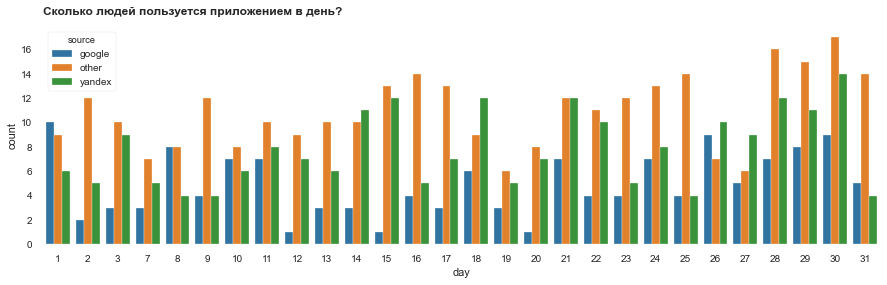

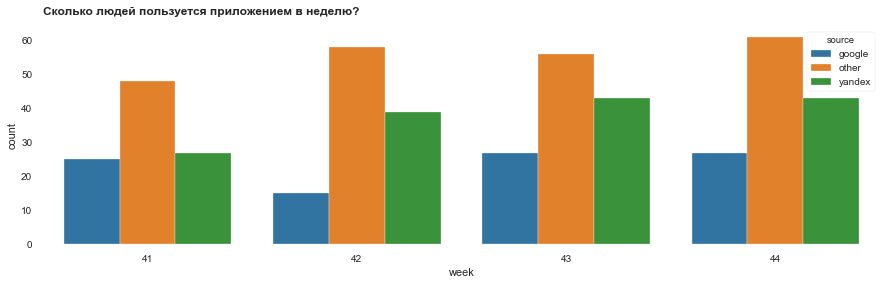

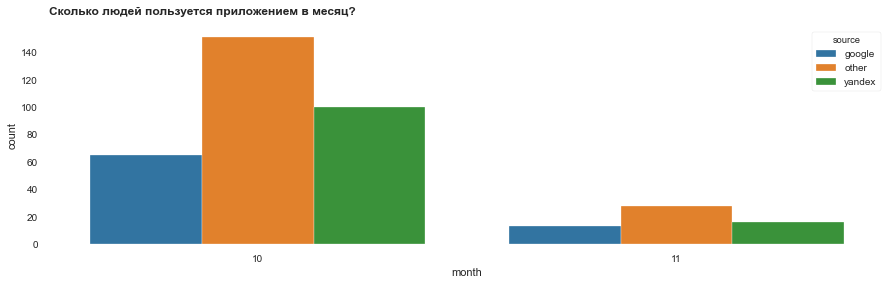

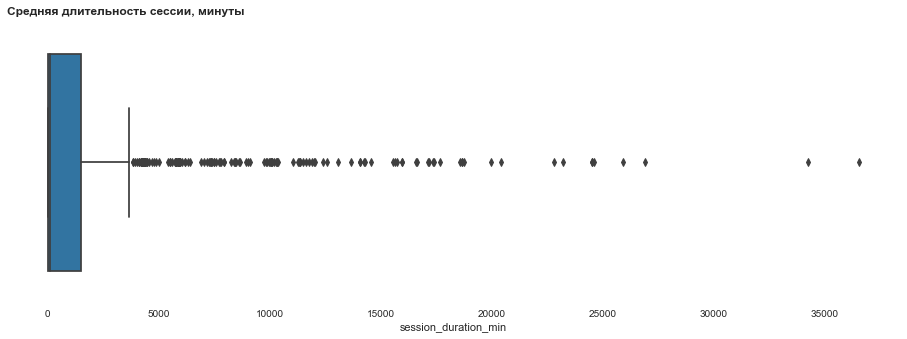

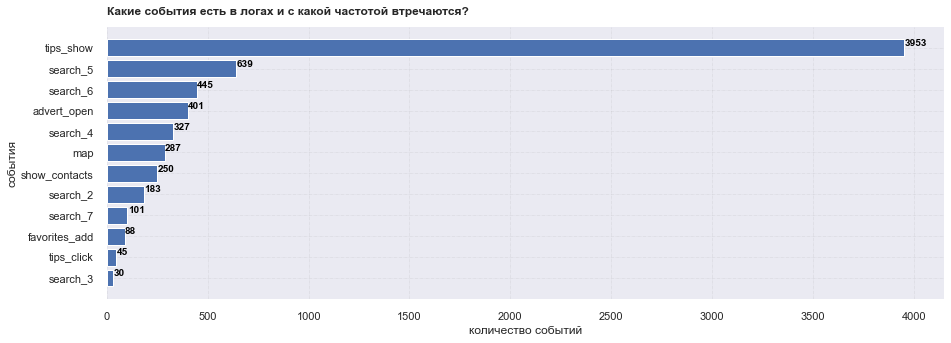

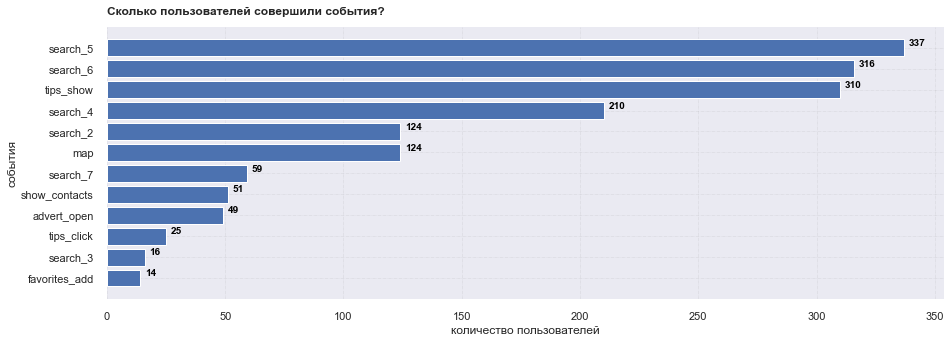

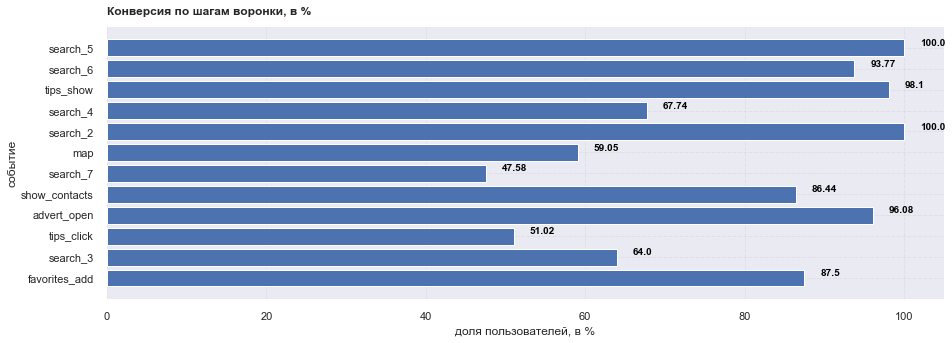

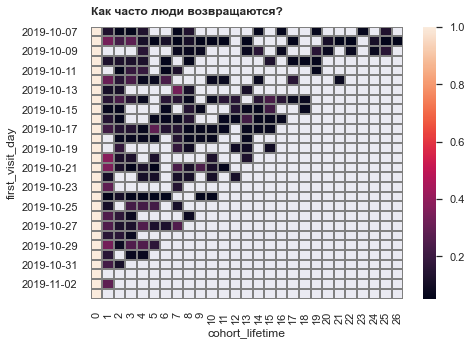

In [26]:
EDA(gr_0)

- больше всего ежедневной активности у пользователей из "другого" источника, меньшего всего - google, к концу месяца активность пользователей увеличивается
- с каждой неделей активность немного увеличивается или остается прежней.
- кол-во пользователей резко уменьшилась в ноябре
- больше всего пользователи просматривают рекомендованные объявления, совершают действия по поиску 5, 6 и 4, а также просматривают карточки объявлений.
- 51 пользователь посмотрел контакты продавца (конверсия равна 51%)
- уже на второй день поток пользователей начал уменьшаться, к середине месяца пользователи почти не заходили в приложение.

**Группа 1:**

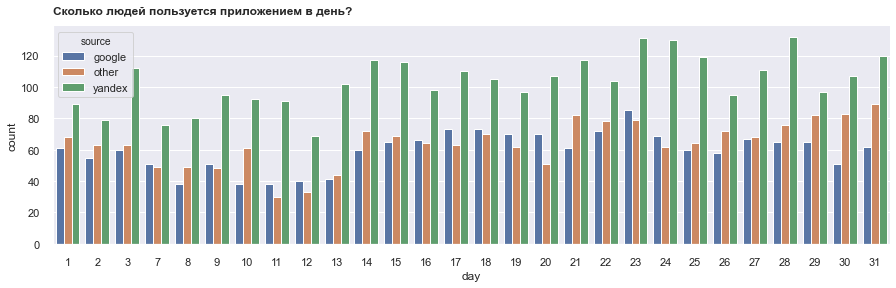

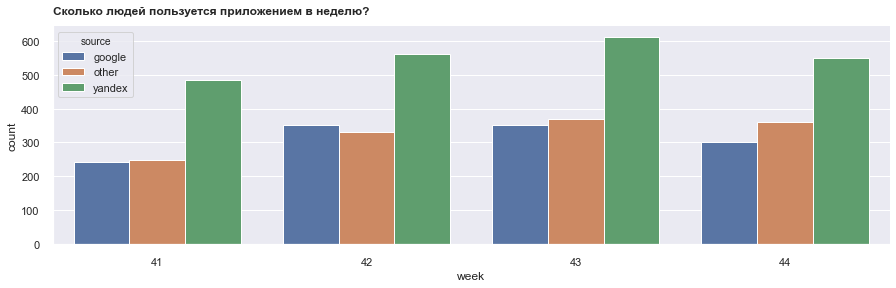

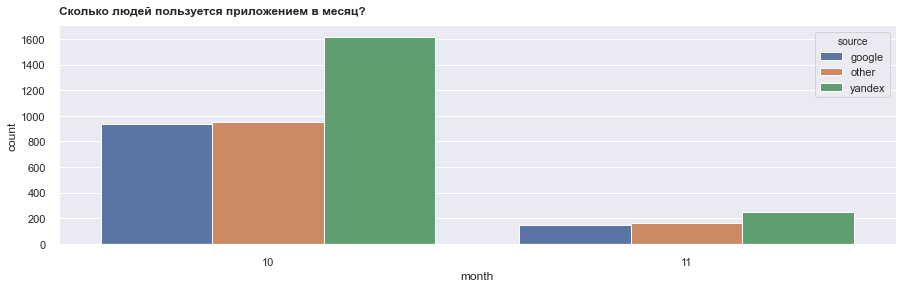

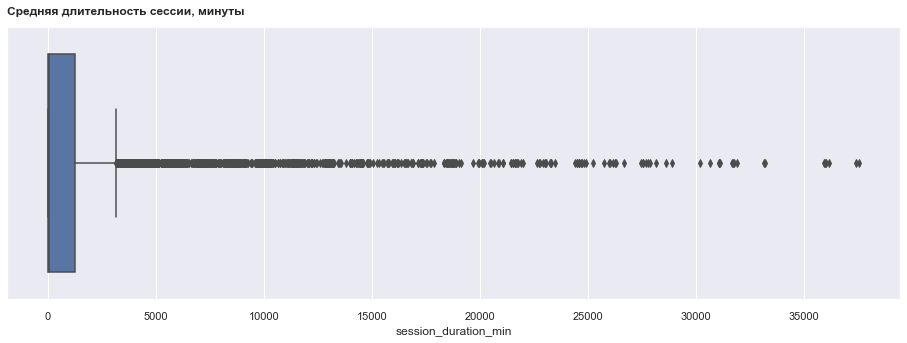

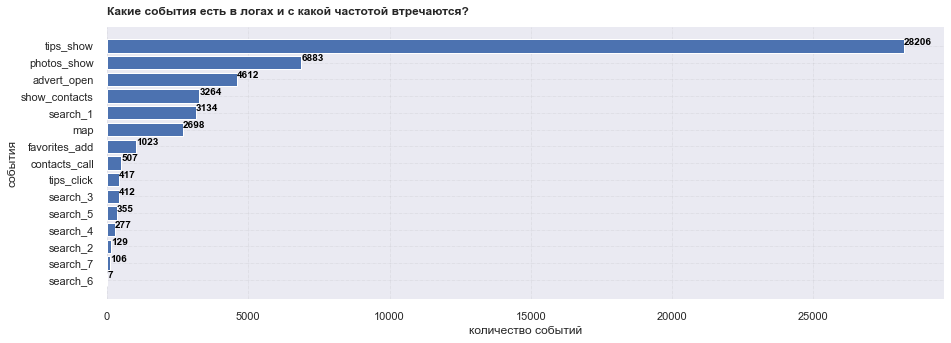

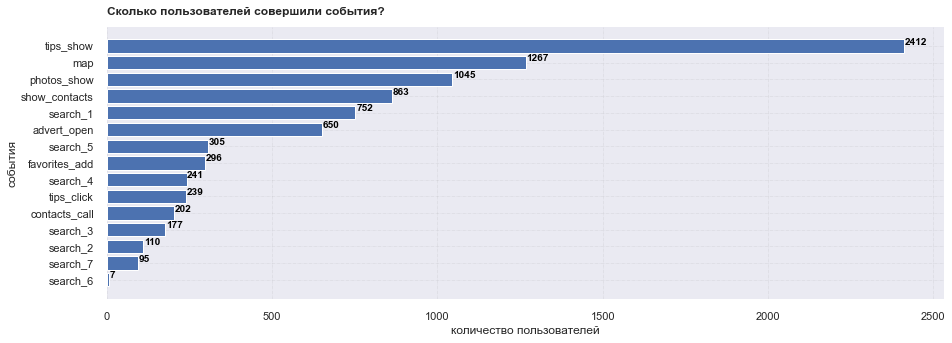

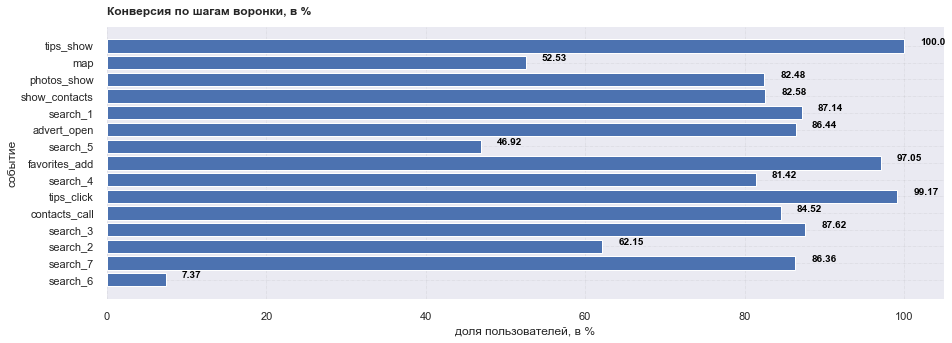

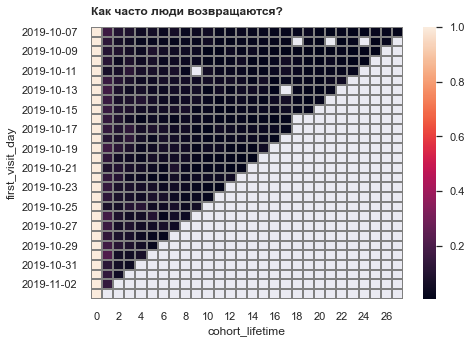

In [27]:
EDA(gr_1)

- больше всего ежедневной активности у пользователей из Яндекса, остальные источники наравне друг с другом
- недельная активность пользователей почти не изменялась
- кол-во пользователей резко уменьшилась в ноябре
- длительность сессии примерно равна - 
- больше всего пользователи просматривают рекомендованные объявления и фотографии по ним, открывают карточки объявлений, смотрят контакты продавца, совершают действия по поиску 1 и смотрят объявления на карте
- 963 пользователя посмотрели контакты продавца (конверсия равна 82%)
- уже на второй день поток пользователей начал уменьшаться, но все равно пользователи открывали приложение.

**Группа 2:**

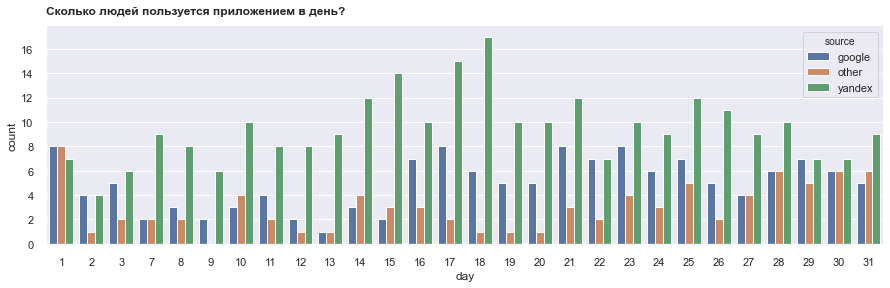

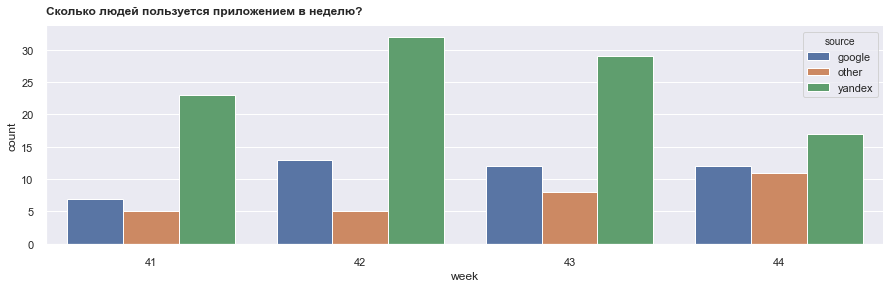

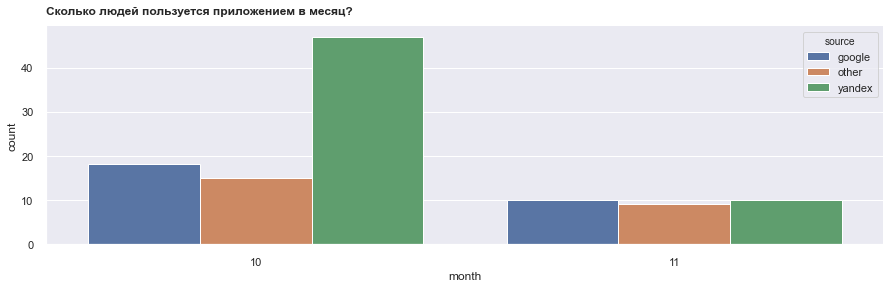

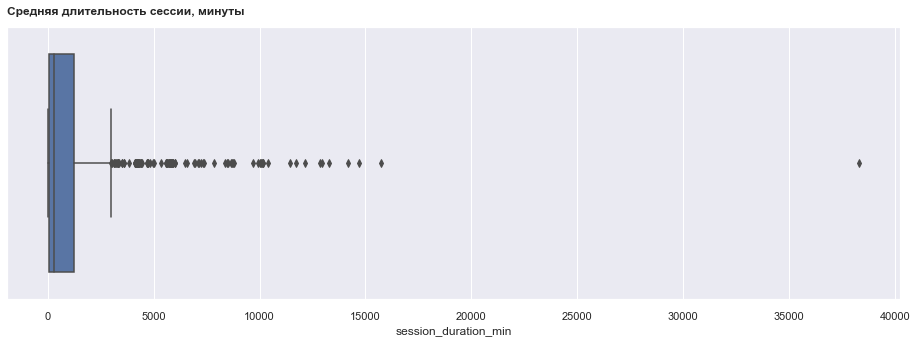

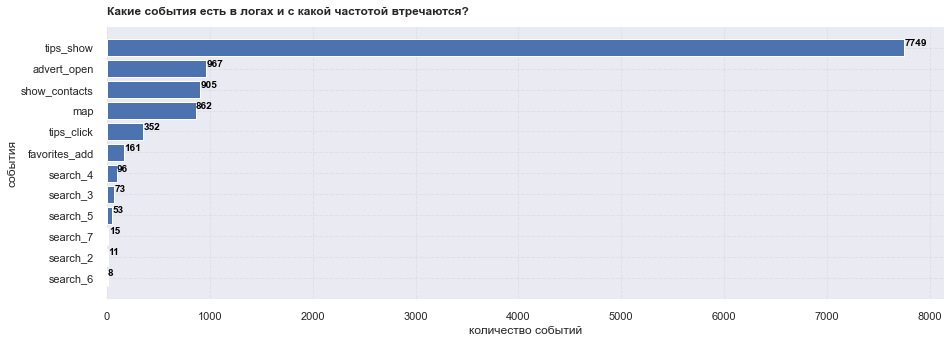

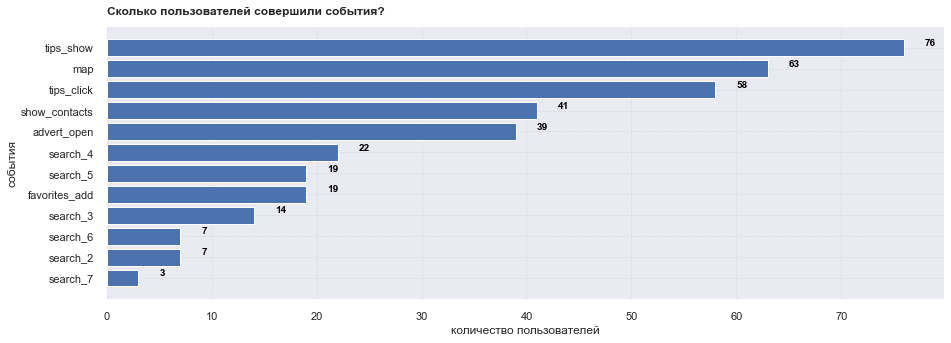

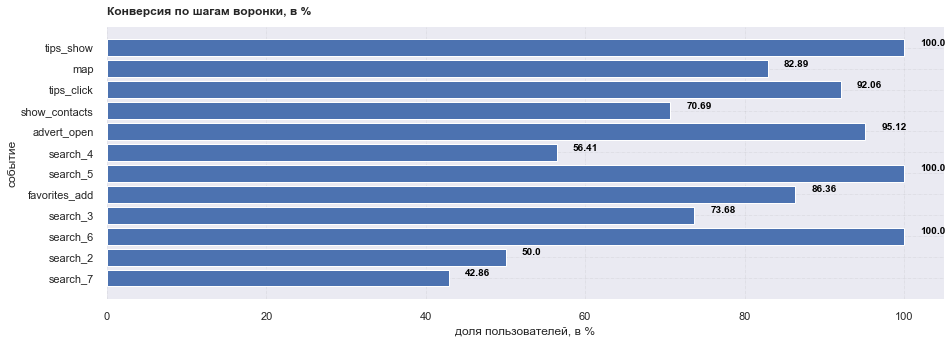

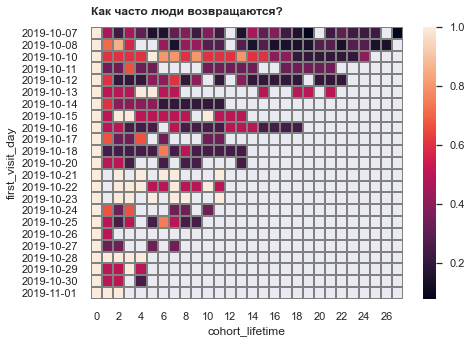

In [28]:
EDA(gr_2)

- больше всего активность пользователей в середине месяца, лидирует Яндекс как источник привлечения клиентов приложения
- на 42 неделе (конец октября) была самая большая активность у пользователей из Яндекса, остальные клиенты из других источников были без изменений
- как и в других группах количество людей в приложении в ноябре стало значительно меньше
- длительность сессии примерно равна - 
- клиенты просмотривают рекомендованные объявления, открывают карточку объявления, смотрят контакты продавца, открывают карту и кликают на рекомендованное объявление
- 41 пользователь посмотрел контакты продавца (конверсия равна 70%)
- видно, что пользователи пользовались приложением (особенно в середине месяца).

**Группа 3:**

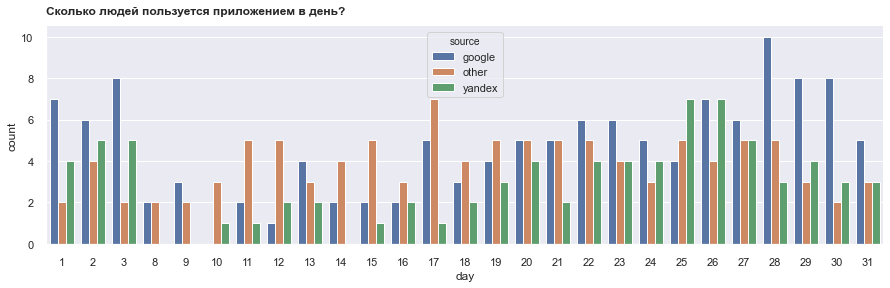

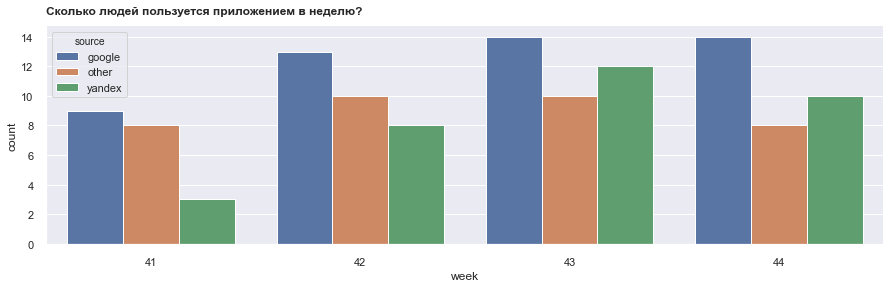

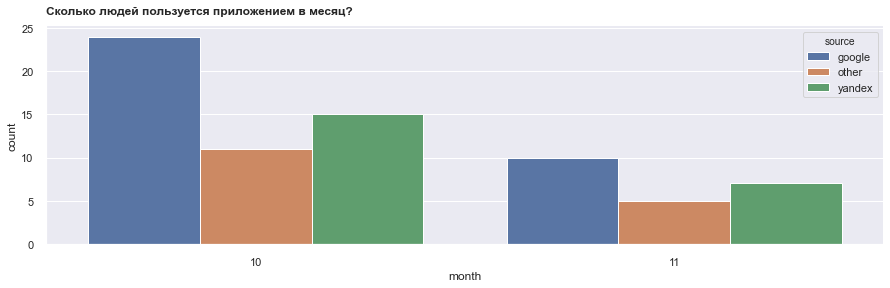

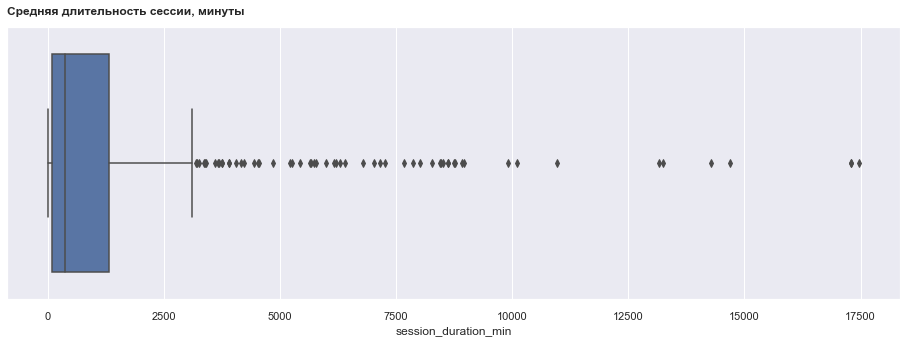

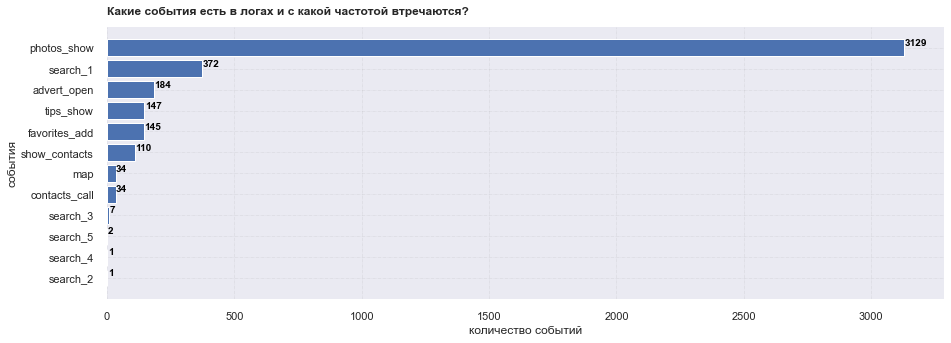

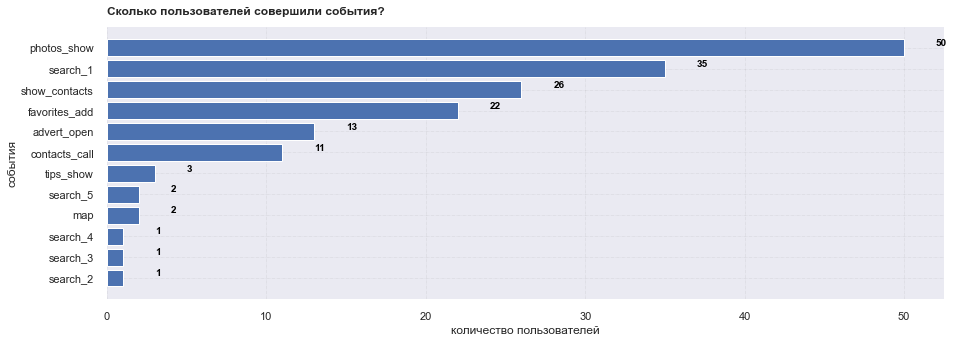

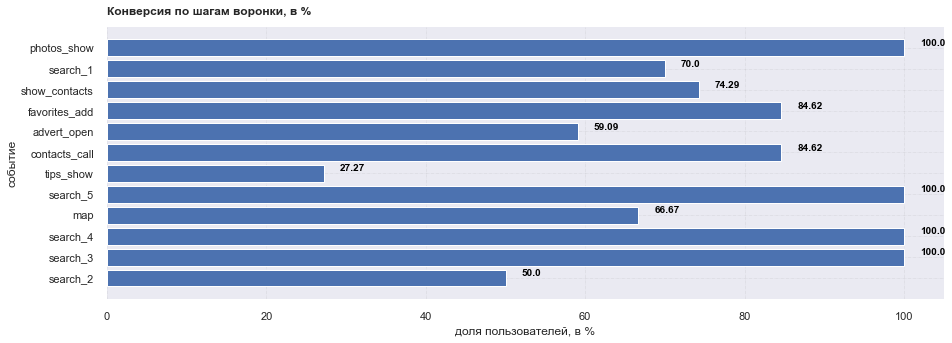

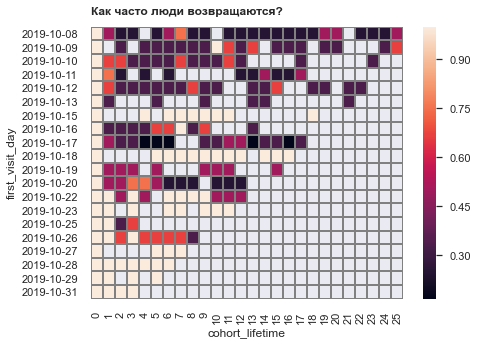

In [29]:
EDA(gr_3)

- еженедельная автиновность больше всего в начале и конце месяца, тут нельзя выбрать единогласного лидера по источнику
- недельная активность пользователей немного увеличивается с течением времени
- в октябре больше всего клиентов из google, в ноябре количество пользователей уменьшается
- длительность сессии примерно равна - 
- пользователи смотрят фотографии объявлений, совершают поиск 1, открывают карточку объявлений, просматривают рекомендованные объявления, добавляют его в избранное  и смотрят контакты
- 26 пользователей посмотрели контакты продавца (конверсия равна 74%)
- показатель удержания клиентов был самый высокий под конец месяца, почти все пользователи, которые скачали приложение в конце периода, пользовались им активно.

Выделены группы пользователей с характерными признаками.

## Проверка гипотез <a name="hyp"></a>

Проверим несколько гипотез по конверсии в просмотр в контакты. Для этого напишем функцию (часть функции EDA()), которая будет показывать воронку событий и конверси по ней, а так же функция, которая проверят статистическую значимость долей.

Выделим часть функции `EDA()` по расчету конверсии в отдельную `funnel()`.

In [30]:
def funnel(df):
    
    """ Функция расчета конверсии в воронке событий  """
    
    events_per_user = (df.groupby('event_name')
                         .agg({'user_id': 'nunique'})
                         .reset_index().sort_values(by='user_id', ascending = False)
                         .rename({'event_name': 'event', 'user_id': 'count_of_users'}, axis=1))

    events_per_user['unique_prev_step'] = events_per_user['count_of_users'].shift(1)

    events_per_user.loc[events_per_user['unique_prev_step'].isna(),'unique_prev_step'] = \
              events_per_user.loc[events_per_user['unique_prev_step'].isna(),'count_of_users']

    events_per_user['prev_step_%'] = round(events_per_user['count_of_users'] / events_per_user['unique_prev_step'] *100, 2)
    
    hist(events_per_user[['event', 'prev_step_%','count_of_users']].sort_values('count_of_users', ascending=True),
     'Конверсия по шагам воронки, в %', 'доля пользователей, в %', 'событие')

Посмотрим статистическу значимость долей z-критерием для каждого шага воронки. Для убодства напишем функцию.

In [31]:
def z_test(successes1, successes2, trials1, trials2, alpha=0.01):
    
    """ Функция расчета статистической значимости
        долей каждого шага воронки z-критерием
    """
    
    # пропорция успехов в первой и второй группах:
    p1 = successes1/trials1
    p2 = successes2/trials2

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes1 + successes2) / (trials1 + trials2)

    # разница пропорций в датасетах
    difference = p1 - p2
    
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print(f'p-значение: {p_value:.3%}')

    if (p_value < alpha):
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')  

In [32]:
def check_hypithesis(df, event_name, exp1, exp2):
    
    """ Функция проверки гипотезы для двух
        экспериментальных групп
    """    
    
    users_events_per_group = df.pivot_table(index='event_name', 
                                        values='user_id', 
                                        columns='group', 
                                        aggfunc=lambda x: x.nunique())

    gr_count_user = (df.pivot_table(index='group', values='user_id', aggfunc=lambda x: x.nunique()))['user_id']
    
    pr1 = users_events_per_group.loc[event_name, exp1] / gr_count_user.loc[exp1]
    pr2 = users_events_per_group.loc[event_name, exp2] / gr_count_user.loc[exp2]
    
    print(f'{pr1:.0%} пользователей с событием {event_name} в группе {exp1}')
    print(f'{pr2:.0%} пользователей с событием {event_name} в группе {exp2}')
    
    z_test(users_events_per_group.loc[event_name, exp1],
           users_events_per_group.loc[event_name, exp2],
           gr_count_user.loc[exp1],
           gr_count_user.loc[exp2])

Первая гипотеза <a name="hyp1"></a> выстроена на предположении о том, что конверсия в просмотры контактов различается у двух групп (Одни пользователи совершают действия `tips_show` и `tips_click`, другие — только `tips_show`).

**Гипитеза H0 - между группами 1 и 2 нет разницы в долях по каждому из событий воронки. Не важно открывают ли они рекомендованные объявления и просматривают их или просто видят рекомендованные объявления. Это не отражается на просмотр контакта продавца.**


In [33]:
list_both_actions = user_by_events.query('tips_show > 0' and 'tips_click > 0').reset_index()['user_id'].tolist()
# list_one_action = user_by_events.query('tips_show > 0' or 'tips_click > 0').reset_index()['user_id'].tolist()

hyp_1 = df
hyp_1['group'] = np.where(hyp_1['user_id'].isin(list_both_actions), 'both_actions', 'one_action')

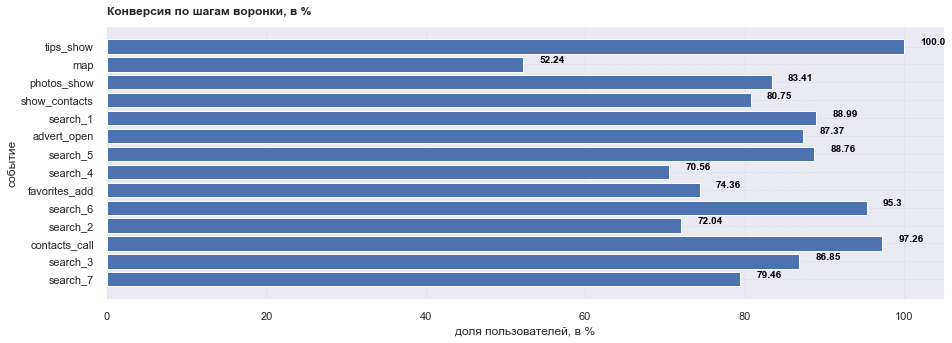

In [34]:
funnel(hyp_1.query('group == "one_action"'))

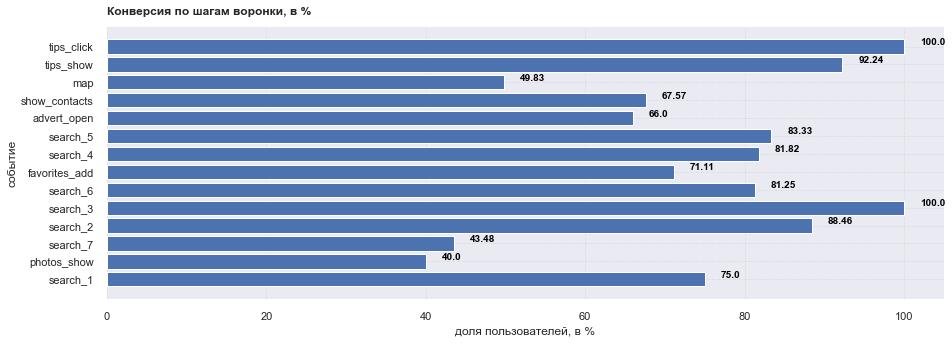

In [35]:
funnel(hyp_1.query('group == "both_actions"'))

In [36]:
print('A\B тестирование:\n')
check_hypithesis(hyp_1, 'show_contacts', 'one_action', 'both_actions')
print()

A\B тестирование:

22% пользователей с событием show_contacts в группе one_action
31% пользователей с событием show_contacts в группе both_actions
p-значение: 0.027%
Отвергаем нулевую гипотезу: между долями есть значимая разница



Есть разница в конверсии шага просмотр контакта продавца.

Вторая гипотеза <a name="hyp2"></a> говорит о том, что не важно какой источник привлечения клиента используется - это не влияет на конверсию шага просмотр контакта продавца.

**Гипитеза H0 - между группами 1 и 2 нет разницы в долях по каждому из событий воронки. Не важно, из какой источника пришел пользователь, это не отражается на просмотр контакта продавца.**

Проверим это.

In [37]:
hyp_2 = df
hyp_2['group'] = hyp_2.source

'Yandex'

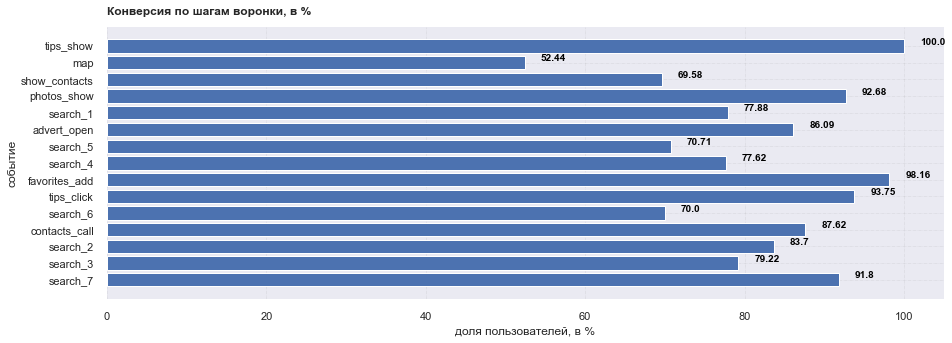

In [38]:
display('Yandex')
funnel(df.query('source == "yandex"'))

'Google'

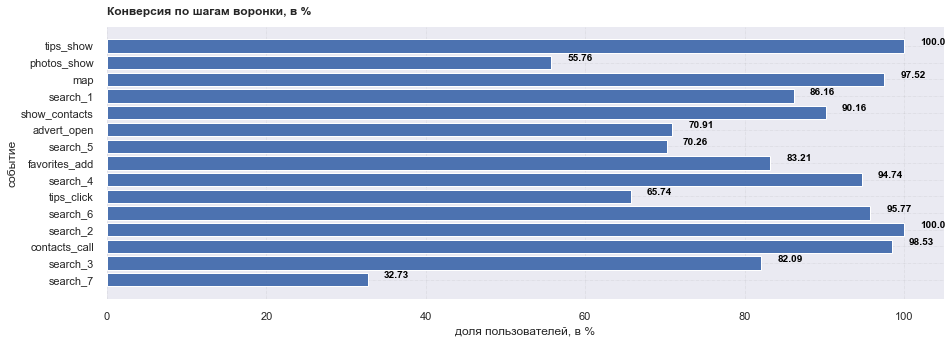

In [39]:
display('Google')
funnel(df.query('source == "google"'))

'Other'

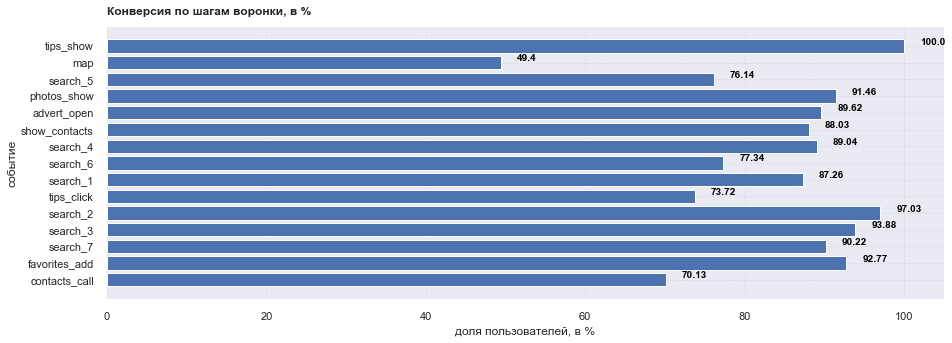

In [40]:
display('Other')
funnel(df.query('source == "other"'))

In [41]:
print('A\B тестирование:\n')
check_hypithesis(hyp_1, 'show_contacts', 'google', 'yandex')
print()

A\B тестирование:

24% пользователей с событием show_contacts в группе google
25% пользователей с событием show_contacts в группе yandex
p-значение: 82.443%
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [42]:
print('A\B тестирование:\n')
check_hypithesis(hyp_1, 'show_contacts', 'other', 'yandex')
print()

A\B тестирование:

19% пользователей с событием show_contacts в группе other
25% пользователей с событием show_contacts в группе yandex
p-значение: 0.005%
Отвергаем нулевую гипотезу: между долями есть значимая разница



In [43]:
print('A\B тестирование:\n')
check_hypithesis(hyp_1, 'show_contacts', 'google', 'other')
print()

A\B тестирование:

24% пользователей с событием show_contacts в группе google
19% пользователей с событием show_contacts в группе other
p-значение: 0.056%
Отвергаем нулевую гипотезу: между долями есть значимая разница



Действия пользователей, скачавшие приложение с помощью Яндекса и Гугла имеют схожие действия в воронке событий и значения коверсии в шаг просмотр контактов.

У пользователей из других источников явно различаются действия по использованию приложения.

## Общие выводы <a name="summary"></a> 

Итого, в ходе исследования стало понятно, что на факт просмотра контактов продавца больше всего влияют такие события как: карта объявлений (клиент ориентируется по карте значительно быстрее и принимает решения о связи с продавцом), просмотр карточки объявлений и их фотографий, и конечно же, рекомендации по объявлению (их просмотр и открытие таковых).


В процессе группировки пользователей на группы по характерным признакам удалось выяснить, что активность клиентов падает к концу месяца, в ноябре наблюдается резкий спад. Самые "активные" пользователи смотрят фотографии объявлений, просматривают рекомендованные объявления и кликают по ним, а также производят действия по поиску 1 (использование различных хэштегов ?). 
Такие пользователи часто пользуются приложением и неоднократно его обновляют\открывают с течением времени (особенно, если добавили объявление в избранное).


Для пользователей, которые уходят в отток или близки к этому вероятно всего не могут разобраться с действиями по поиску объявлений, используют разные типы поисков, это их утомляет, и они просто не хотят продолжать пользоваться приложением. Да, они просматривают рекомендованные объявления, но не доходят до просмотра фотографий. Это связано с тем, что для просмотра фотографий обязательно нужно заходить на карточку объявления. Этот шаг в воронке явно лишний и может быть исключен.


Есть вероятность того, что источник привлечения отражается в действиях пользователей. Действия пользователей, скачавшие приложение с помощью Yandex и Google имеют схожие действия в воронке событий и значения конверсии в шаг просмотр контактов. У пользователей из других источников явно различаются действия по использованию приложения. С другими источниками нужно прорабатывать шаги воронки, чтобы для клиентов приложения их действия были понятными и логичными.


Презентация с результатами исследования по ссылке: https://yadi.sk/d/oabLNtzRVRfI3Q